## Content Analysis Module

#### Objective

This notebook will cover the entire content analysis pipeline, including:

- Preprocessing (Step 3.1)
- Vectorization (Step 3.2)
- Topic modeling (Step 3.3)
- Keyword extraction (Step 3.4)
- Sentiment analysis (Step 3.5)
- Categorization (Step 3.6)

**Preprocessig pipeline**

| Substep | Concept                     | Purpose                                 |
| ------- | --------------------------- | --------------------------------------- |
| 3.1     | 🔤 **Text preprocessing**   | Clean and normalize text                |
| 3.2     | 🔢 **TF-IDF vectorization** | Turn text into numbers for ML models    |
| 3.3     | 📚 **Topic modeling**       | Discover dominant themes in content     |
| 3.4     | 🔑 **Keyword extraction**   | Find top keywords                       |
| 3.5     | 😊 **Sentiment analysis**   | Detect positivity/negativity            |
| 3.6     | 🏷️ **Categorization**      | Assign content to categories (optional) |


#### Required Setup

In [49]:
from pathlib import Path
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer # Sentiment Analysis
import string
import pandas as pd
import sqlite3

from sklearn.feature_extraction.text import TfidfVectorizer # for TF-IDF Modeling
from sklearn.decomposition import NMF # For topic modelling NMF
from sklearn.cluster import KMeans # For semantic clustering
from sklearn.decomposition import PCA # For cluster visualization

from sentence_transformers import SentenceTransformer # for semantic embeddings

from wordcloud import WordCloud
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Download stopwords + tokenizer once
nltk.download("punkt_tab") # pre-trained tokenizer model for sentence and word splitting.
nltk.download("stopwords") # Stopwords are common words that appear frequently but carry little meaningful information: e.g. the, is, and, on..

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vinothhaldorai/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vinothhaldorai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# Define English stopwords
stop_words = set(stopwords.words("english"))

# Download VADER lexicon for sentiment analysis
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vinothhaldorai/nltk_data...


True

### Text Preprocessing (Step 3.1)

Raw text contains
- irrelevant symbols (punctuation, emojis, etc.)
- Stopwords (e.g., "the", "and", "in")
- Inconsistent casing
- Words with the same meaning in different forms ("running", "run")

Cleaning improves the quality of:
- TF-IDF vectorization
- Topic modeling
- Sentiment analysis

In [5]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Convert to Lowercase
    text = text.lower()

    # 2. Remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Rejoin as clean string
    return " ".join(tokens)

#### Connect to the database and load the content table

In [6]:
"""
# Connnect to the SQL database
conn = sqlite3.connect("data/content_data.db")

# Load the content table into a DataFrame
combined_df = pd.read_sql_query("SELECT * FROM content", conn)

# Close the connection
conn.close()
"""

# Define path to root-level "data" folder
data_dir = Path.cwd().parent / "data"
db_path = data_dir / "content_data.db"

# Connnect to the SQL database
conn = sqlite3.connect(db_path)

# Load the content table into a DataFrame
combined_df = pd.read_sql_query("SELECT * FROM content", conn)

# Close the connection
conn.close()

print("Loaded content data from:", db_path)
combined_df.head()

Loaded content data from: /Users/vinothhaldorai/Documents/Vinoth/PROJECTS/content-marketing-agent/data/content_data.db


,title,publishedAt,source,publishedDate
0,AI in content marketing: How creators and mark...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08
1,AI in Marketing recent news | Content Marketin...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08
2,A Complete Guide to Adopting AI in Content Mar...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08
3,AI tools for content marketing : r/marketing,2025-07-08 23:50:58+00:00,Google Search,2025-07-08
4,Artificial Intelligence And The Future Of Cont...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08


In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          46 non-null     object
 1   publishedAt    46 non-null     object
 2   source         46 non-null     object
 3   publishedDate  46 non-null     object
dtypes: object(4)
memory usage: 1.6+ KB


In [8]:
# Ensure the date column is in proper UTC format
combined_df["publishedAt"] = pd.to_datetime(combined_df["publishedAt"], utc=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   title          46 non-null     object             
 1   publishedAt    46 non-null     datetime64[ns, UTC]
 2   source         46 non-null     object             
 3   publishedDate  46 non-null     object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 1.6+ KB


#### Apply Preprocessing

In [9]:
# Load CSV updated in data collection step
# combined_df = pd.read_csv("data/combined_data.csv", parse_dates=["publishedAt"])

# Apply text cleaning
combined_df["clean_title"] = combined_df["title"].apply(clean_text)

# preview result
combined_df[["title", "clean_title"]].head()

,title,clean_title
0,AI in content marketing: How creators and mark...,ai content marketing creators marketers using ai
1,AI in Marketing recent news | Content Marketin...,ai marketing recent news content marketing ins...
2,A Complete Guide to Adopting AI in Content Mar...,complete guide adopting ai content marketing s...
3,AI tools for content marketing : r/marketing,ai tools content marketing rmarketing
4,Artificial Intelligence And The Future Of Cont...,artificial intelligence future content marketing


In [10]:
# print(clean_text("This is a sample text for text preprocessing. this is a bunch of random words"))

### TF-IDF Vectorization (Step 3.2)

TF: Term Frequency – how often a word appears in a document

IDF: Inverse Document Frequency – penalizes common words across all docs - How rare that word is across all documents

TF-IDF helps turn text into numbers that reflect how important a word is in a specific document, compared to how common it is in general.

#### Build TF-IDF Model

In [12]:
# Create vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=100, # Only keep 100 most important words. Keep 100 now so that model is faster and easier. Can increase later (500, 1000) for deeper models
    ngram_range=(1, 2) # Look at single words (unigrams) e.g. AI and pairs (bigrams) e.g. "Content Marketing"
)

# Fit and transform the cleaned titles
# fit_transform -> first learns the vocabulary and then converts text into matrix (rows = docs, cols = words, value = TF-IDF score)
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_df["clean_title"])

# Convert to DataFrame for inspection
# tfidf outputs a sparse matrix (where most values are zero). Convert to Dataframe
# Each row is title, each column is word, value = importance score for that word in that title
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add back original titles for context
tfidf_df["title"] = combined_df["title"]

# Preview result
tfidf_df.head()

,10,10 ai,11,11 ai,2022,2023,2024,2025,2025 annual,affiliate,...,review,sql,stingray,stingray group,tools,top,top 10,update,use,title
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,AI in content marketing: How creators and mark...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,AI in Marketing recent news | Content Marketin...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,A Complete Guide to Adopting AI in Content Mar...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.377672,0.0,0.0,0.0,0.0,AI tools for content marketing : r/marketing
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,Artificial Intelligence And The Future Of Cont...


In [65]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Columns: 101 entries, 10 to title
dtypes: float64(100), object(1)
memory usage: 36.4+ KB


### Topic Modeling (NMF or LDA) (Step 3.3)

NMF - Non-negative Matrix Factorization (works well for short texts like titles. It uses TF-IDF matrix as input)

Topic modeling is a way to:
- Automatically discover the main themes or topics in a collection of documents (in this case - titles)
- Cluster similar title together by topic

In [16]:
"""
Get breakdown of 5 topics in your titles
Each topic has a set of keywords describing it
"""

# Fit topic model
nmf_model = NMF(
    n_components = 5, # defines number of topics (top words) (experiment with 3, 5, 10 etc.)
    random_state = 42 
)

nmf_model.fit(tfidf_matrix)

# Get top words per topic (5 words)
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model.components_): # nmf_model.components_ gives a list of topics
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]] # sort them to get the top 5 words per topic.
    print(f"🔹 Topic #{topic_idx + 1}: {', '.join(top_words)}")


🔹 Topic #1: content marketing, content, marketing, ai, ai content
🔹 Topic #2: ai tools, 10, top 10, 10 ai, tools
🔹 Topic #3: ai marketing, marketing tools, marketing, tools, ai
🔹 Topic #4: new, directors, director, charest new, announces
🔹 Topic #5: sql, 2022, affiliate, need, guide


### Extract top keywords from each title (Step 3.4)

In [19]:
"""
Extract top key words from each individual title, using the TF-IDF matrix
For each title (row in TF-IDF matrix), we find the top 3 words with highest importance.
These are the most representatitve keywords for that title
"""

# Get top TF-IDF keywords per title
def extract_keywords_from_vector(vector, feature_names, top_n=3): # Top 3 words with highest importance
    sorted_indices = vector.argsort()[::-1][:top_n]
    return [feature_names[i] for i in sorted_indices]


In [20]:
# Apply function to each title
combined_df["top_keywords"] = [
    extract_keywords_from_vector(row, tfidf_vectorizer.get_feature_names_out())
    for row in tfidf_matrix.toarray()
]

# Preview with keywords
combined_df[["title", "top_keywords"]].head()

,title,top_keywords
0,AI in content marketing: How creators and mark...,"[ai, ai content, content marketing]"
1,AI in Marketing recent news | Content Marketin...,"[marketing, content marketing, ai marketing]"
2,A Complete Guide to Adopting AI in Content Mar...,"[complete, guide, ai content]"
3,AI tools for content marketing : r/marketing,"[ai tools, content marketing, content]"
4,Artificial Intelligence And The Future Of Cont...,"[future, content marketing, content]"


#### Visualize the insights from Extracting top keywords (Visualizing Step 3.4)

- Generate a word cloud of the most frequent keywords
- Generate a bar chart of the top 15 most frequent keywords

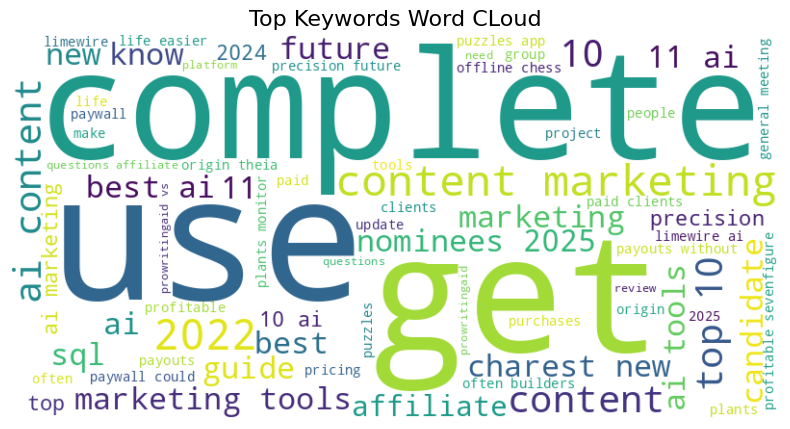

In [30]:
# Flatten the list of keywords list into 1 big list
all_keywords = [keyword for sublist in combined_df["top_keywords"] for keyword in sublist]

# Count keyword frequencies
keyword_counts = Counter(all_keywords)

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(keyword_counts)

# Plot
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear") # https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html
plt.axis("off")
plt.title("Top Keywords Word CLoud", fontsize=16)
plt.show()

/Users/vinothhaldorai/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


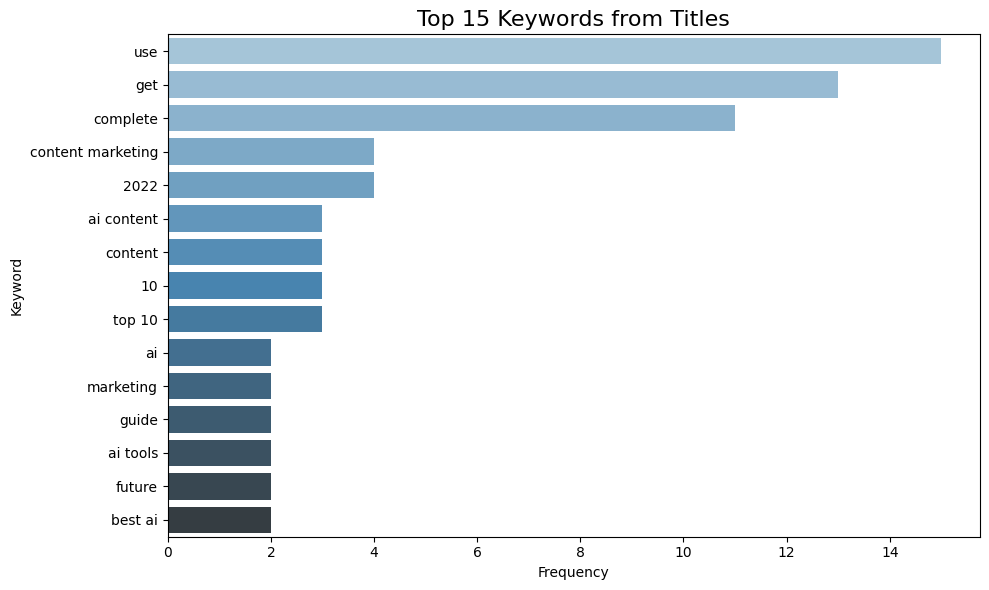

In [32]:
# Generate barchart of top keywords

# Get top 15 keywords
top_keywords = keyword_counts.most_common(15)
keywords, counts = zip(*top_keywords)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(keywords), palette="Blues_d")
plt.title("Top 15 Keywords from Titles", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

### Sentiment Analysis (Step 3.5)

- Sentiment analysis is the process of using Natural Language Processing (NLP) to determine the emotional tone behind a piece of text.
- It classifies text as: Positive/ Negative/ Neutral
- Apply to "titles" and classify as Optimistic/ Critical/ Informative

#### Tools used

**NLTK VADER**
- Variance Aware Dictionary and sEntiment Reasoner
- Built for short text (e.g. tweets, headlines, product reviews) - suitable for tites

In [37]:
# Initialize Vader
sia = SentimentIntensityAnalyzer() # create sentiment analyzer object with access to pre-trained lexicon

# Apply Vader to titles (Vader Sentiment scoring)
# Apply to "title" column, not "clean_title" to capture tone/ emotion elements that are not lost to pre-processing

# compound -> normalized sentiment score between -1 (most negative) and +1 (most positive). Used for single-score interpretation
# Vader returns 4 scores: pos, neu, neg, and compound

combined_df["sentiment_score"] = combined_df["title"].apply(lambda x: sia.polarity_scores(x)["compound"])

combined_df.head()

,title,publishedAt,source,publishedDate,clean_title,top_keywords,sentiment_score
0,AI in content marketing: How creators and mark...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai content marketing creators marketers using ai,"[ai, ai content, content marketing]",0.0000
1,AI in Marketing recent news | Content Marketin...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai marketing recent news content marketing ins...,"[marketing, content marketing, ai marketing]",0.0000
2,A Complete Guide to Adopting AI in Content Mar...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,complete guide adopting ai content marketing s...,"[complete, guide, ai content]",0.0000
3,AI tools for content marketing : r/marketing,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai tools content marketing rmarketing,"[ai tools, content marketing, content]",0.0000
4,Artificial Intelligence And The Future Of Cont...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,artificial intelligence future content marketing,"[future, content marketing, content]",0.4767


In [40]:
# Add human-readable sentiment labels
# Vader standard thresholds
# >= 0.05 clearly positive
# <= -0.05 clearly negative
# between neutral

def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [41]:
combined_df["sentiment_label"] = combined_df["sentiment_score"].apply(label_sentiment)
combined_df.head()

,title,publishedAt,source,publishedDate,clean_title,top_keywords,sentiment_score,sentiment_label
0,AI in content marketing: How creators and mark...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai content marketing creators marketers using ai,"[ai, ai content, content marketing]",0.0000,Neutral
1,AI in Marketing recent news | Content Marketin...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai marketing recent news content marketing ins...,"[marketing, content marketing, ai marketing]",0.0000,Neutral
2,A Complete Guide to Adopting AI in Content Mar...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,complete guide adopting ai content marketing s...,"[complete, guide, ai content]",0.0000,Neutral
3,AI tools for content marketing : r/marketing,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai tools content marketing rmarketing,"[ai tools, content marketing, content]",0.0000,Neutral
4,Artificial Intelligence And The Future Of Cont...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,artificial intelligence future content marketing,"[future, content marketing, content]",0.4767,Positive


#### Visualize Sentiment distribution

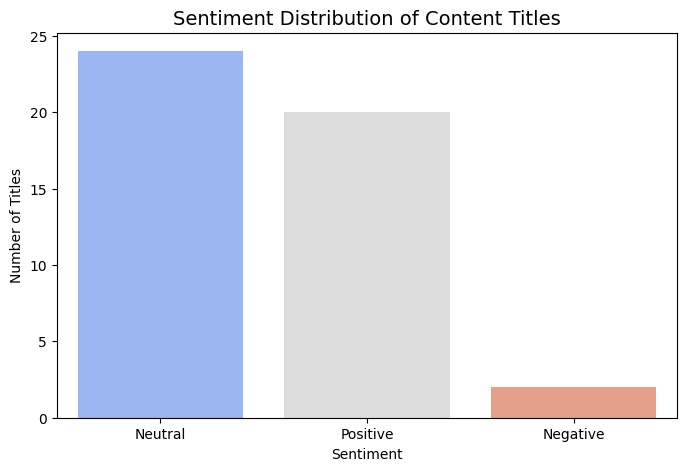

In [42]:
plt.figure(figsize=(8,5))
sns.countplot(data=combined_df, x="sentiment_label", palette="coolwarm")
plt.title("Sentiment Distribution of Content Titles", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Titles")
plt.show()

### Semantic Clustering of similar titles (Step 3.6)

We have list of titles with keywords and sentiment.

Now we need to know which titles are about similar ideas. Clustering will help to
- Group similar content
- Reduce Redundancy
- Make decisions like: "Do I already have content around ths topic?"
- It can power content recommendation or brief generator agents

| Concept                  | Description                                                   |
| ------------------------ | ------------------------------------------------------------- |
| Sentence Embeddings      | A way to turn entire titles into meaningful numerical vectors |
| Cosine Similarity        | A metric to compare similarity between two vectors            |
| KMeans Clustering        | Group titles into n clusters based on semantic similarity     |
| Dimensionality Reduction | Use PCA or UMAP to visualize clusters                         |


#### Tools used

sentence-transformers for semantic embeddings

sklearn.cluster.KMeans for clustering

seaborn or plotly for optional visualizations

In [47]:
# Load pre-trained sentence transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embedding for each title
# Converts each title (sentence) into a 384-dimensional vector
# Unlike TF-IDF, these capture context and semantics. e.g "AI in marketing" and "marketing with AI tools" will have similar vectors
embeddings = model.encode(combined_df["title"].tolist(), show_progress_bar=True)

# Cluster with kMeans
n_clusters = 5 # Every title is assigned a cluster number e.g. (0-4)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
combined_df["cluster"] = kmeans.fit_predict(embeddings)

combined_df.head()

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,title,publishedAt,source,publishedDate,clean_title,top_keywords,sentiment_score,sentiment_label,cluster
0,AI in content marketing: How creators and mark...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai content marketing creators marketers using ai,"[ai, ai content, content marketing]",0.0000,Neutral,2
1,AI in Marketing recent news | Content Marketin...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai marketing recent news content marketing ins...,"[marketing, content marketing, ai marketing]",0.0000,Neutral,2
2,A Complete Guide to Adopting AI in Content Mar...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,complete guide adopting ai content marketing s...,"[complete, guide, ai content]",0.0000,Neutral,2
3,AI tools for content marketing : r/marketing,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,ai tools content marketing rmarketing,"[ai tools, content marketing, content]",0.0000,Neutral,2
4,Artificial Intelligence And The Future Of Cont...,2025-07-08 23:50:58+00:00,Google Search,2025-07-08,artificial intelligence future content marketing,"[future, content marketing, content]",0.4767,Positive,2


#### Inspect Clusters

In [48]:
# Inspect clusters

# Show sample titles per cluster
for cluster_id in range(n_clusters):
    print(f"\n Cluster {cluster_id}")
    print(combined_df[combined_df["cluster"]== cluster_id]["title"].head(3).to_string(index=False))


 Cluster 0
Spatial Computing Takes The Lead For Apple At W...
Struggling to Get Clients Even Though You’re Gr...
I'm an expert affilliate marketer, and I can he...

 Cluster 1
    Supabase MCP can leak your entire SQL database
Dynamical origin of Theia, the last giant impac...
Plants monitor the integrity of their barrier b...

 Cluster 2
AI in content marketing: How creators and marke...
AI in Marketing recent news | Content Marketing...
A Complete Guide to Adopting AI in Content Mark...

 Cluster 3
Cloudflare’s bot paywall could ignite a tokeniz...
           30% off code for Blaze ai – use "30OFF"
                                   Comment a color

 Cluster 4
Stingray Group Board of Directors announces tha...
Stingray Group Board of Directors announces tha...
Breaking Git with a carriage return and cloning...


#### Visualize Clusters with PCA

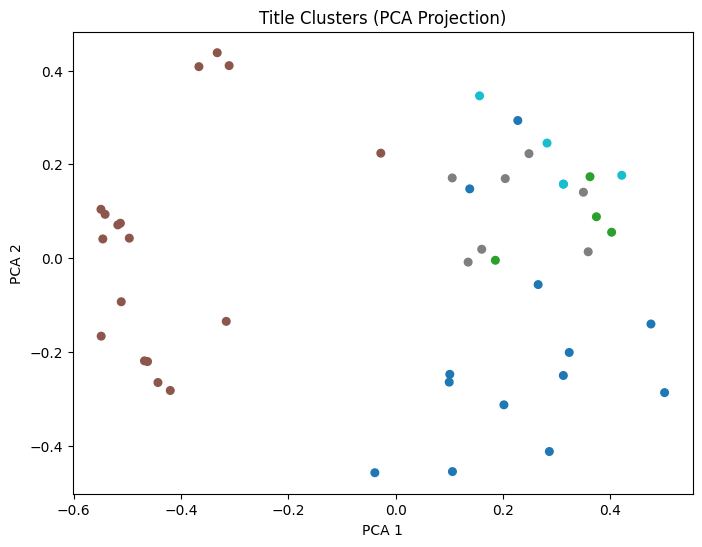

In [51]:
# Reduce dimensions for plotting
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=combined_df["cluster"], cmap="tab10", s=30)
plt.title("Title Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [53]:
combined_df.tail()

,title,publishedAt,source,publishedDate,clean_title,top_keywords,sentiment_score,sentiment_label,cluster
41,TOP 11 AI MARKETING TOOLS YOU SHOULD USE (Upda...,2022-07-13 15:25:00+00:00,RSS,2022-07-13,top 11 ai marketing tools use updated 2022,"[use, 11, 11 ai]",0.3680,Positive,2
42,Most Frequently Asked Questions About Affiliat...,2022-06-01 13:03:00+00:00,RSS,2022-06-01,frequently asked questions affiliate marketing,"[questions affiliate, questions, affiliate]",0.0000,Neutral,0
43,What is Blockchain: Everything You Need to Kno...,2022-04-18 05:49:00+00:00,RSS,2022-04-18,blockchain everything need know 2022,"[know, need, 2022]",0.0000,Neutral,1
44,ProWritingAid VS Grammarly: Which Grammar Chec...,2022-03-13 15:04:00+00:00,RSS,2022-03-13,prowritingaid vs grammarly grammar checker bet...,"[prowritingaid vs, prowritingaid, 2022]",0.4404,Positive,4
45,Sellfy Review 2022: How Good Is This Ecommerce...,2022-03-12 11:54:00+00:00,RSS,2022-03-12,sellfy review 2022 good ecommerce platform,"[platform, review, 2022]",0.4404,Positive,0
